## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint, time, random, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# Lets check the nltk_data
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Lets split into training set and validation set
# So, reproduce the results, lets use a seed
random.seed(111)
train_set, validation_set = train_test_split(nltk_data, test_size=0.05)
print(len(train_set))
print(len(validation_set))

3718
196


In [5]:
print(validation_set[:5])

[[('Diaper', 'NOUN'), ('shortages', 'NOUN'), ('this', 'DET'), ('summer', 'NOUN'), ('limited', 'VERB'), ('growth', 'NOUN'), ('at', 'ADP'), ('Stork', 'NOUN'), ('Diaper', 'NOUN'), ('Services', 'NOUN'), (',', '.'), ('Springfield', 'NOUN'), (',', '.'), ('Mass.', 'NOUN'), (',', '.'), ('where', 'ADV'), ('business', 'NOUN'), ('is', 'VERB'), ('up', 'ADP'), ('25', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('*T*-1', 'X')], [('The', 'DET'), ('president', 'NOUN'), ('could', 'VERB'), ('probably', 'ADV'), ('not', 'ADV'), ('avoid', 'VERB'), ('this', 'DET'), ('restriction', 'NOUN'), ('by', 'ADP'), ('*-1', 'X'), ('choosing', 'VERB'), ('people', 'NOUN'), ('willing', 'ADJ'), ('*', 'X'), ('to', 'PRT'), ('serve', 'VERB'), ('without', 'ADP'), ('pay', 'NOUN'), (',', '.'), ('because', 'ADP'), ('the', 'DET'), ('Anti-Deficiency', 'NOUN'), ('Act', 'NOUN'), ('prohibits', 'VERB'), ('voluntary', 'ADJ'), ('service', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('government', 'NOUN'), ('.', '.')], [('Pakistan', 'NOUN'), ("'s",

In [6]:
# Lets get a full list of tagged words as there is a list between a list
train_tagged_words = [tup for combo in train_set for tup in combo]
print(len(train_tagged_words))

95435


In [7]:
# lets extract tokens
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'problem',
 'here',
 'goes',
 'well',
 'beyond',
 '*',
 'twisting',
 'legal',
 'doctrine']

In [8]:
# Vocabulary
V = set(tokens)
print(len(V))

12029


In [9]:
# Lets see the tags in the corpus
T = set([pair[1] for pair in train_tagged_words])
print(len(T))

12


In [10]:
# As mentioned in the assignment, there are exactly 12 tags. Lets check the tag names
print(T)

{'X', '.', 'PRT', 'VERB', 'ADV', 'CONJ', 'PRON', 'DET', 'NOUN', 'ADJ', 'NUM', 'ADP'}


### Build the vanilla Viterbi based POS tagger

In [11]:
# Checking the size of train tagged words
len(train_tagged_words)

95435

### Emission Probabilities

In [12]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [13]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [14]:
# examples

# board
print("board")
print(word_given_tag('board', 'NOUN'))
print(word_given_tag('board', 'VERB'))
print(word_given_tag('board', 'ADV'), "\n")

# told
print("will")
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))
print(word_given_tag('will', 'ADV'))

# book
print("\n", "more")
print(word_given_tag('more', 'VERB'))
print(word_given_tag('more', 'ADV'))

board
(28, 27354)
(0, 12896)
(0, 3000) 

will
(1, 27354)
(267, 12896)
(0, 3000)

 more
(0, 12896)
(81, 3000)


### Transition Probabilities

In [15]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# examples
print(t2_given_t1(t2='PRT', t1='CONJ'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('VERB', 'NOUN'))
print(t2_given_t1('ADV', 'VERB'))
print(t2_given_t1('ADJ', 'VERB'))
print(t2_given_t1('DET', 'NOUN'))
print(t2_given_t1('CONJ', 'VERB'))

(10, 2157)
(1413, 12896)
(4021, 27354)
(1057, 12896)
(823, 12896)
(357, 27354)
(72, 12896)


In [17]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,X,.,PRT,VERB,ADV,CONJ,PRON,DET,NOUN,ADJ,NUM,ADP
X,0.075750,0.164364,0.184374,0.204542,0.025409,0.010322,0.055741,0.054788,0.062569,0.016198,0.002859,0.143084
.,0.027912,0.093071,0.002334,0.088943,0.052863,0.058158,0.065787,0.172590,0.221594,0.044247,0.080775,0.091635
PRT,0.013752,0.042895,0.001965,0.402096,0.009168,0.002292,0.017354,0.102161,0.249181,0.081205,0.057629,0.020301
VERB,0.219215,0.035282,0.031638,0.168734,0.081963,0.005583,0.036213,0.133917,0.109569,0.063818,0.022953,0.091114
ADV,0.022667,0.135667,0.014667,0.347000,0.077000,0.007000,0.015333,0.068667,0.031333,0.129333,0.032667,0.118667
CONJ,0.008809,0.035698,0.004636,0.159944,0.052851,0.000464,0.057487,0.119611,0.349096,0.117756,0.041261,0.052388
PRON,0.090107,0.039877,0.012653,0.486963,0.034509,0.004985,0.007669,0.009202,0.208589,0.074386,0.007285,0.023773
DET,0.045283,0.018453,0.000243,0.039699,0.012626,0.000486,0.003521,0.005827,0.637125,0.205172,0.022581,0.008984
NOUN,0.028844,0.241062,0.043613,0.146999,0.016999,0.042882,0.004826,0.013051,0.264276,0.012137,0.009432,0.175879
ADJ,0.020293,0.064870,0.010479,0.012475,0.004325,0.016966,0.000665,0.004824,0.702262,0.066035,0.021124,0.075682


In [19]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('ADV', '.'))
print(t2_given_t1('ADJ', '.'))

(2469, 11142)
(991, 11142)
(589, 11142)
(493, 11142)


In [20]:
tags_df.loc['.', :]

X       0.027912
.       0.093071
PRT     0.002334
VERB    0.088943
ADV     0.052863
CONJ    0.058158
PRON    0.065787
DET     0.172590
NOUN    0.221594
ADJ     0.044247
NUM     0.080775
ADP     0.091635
Name: ., dtype: float32

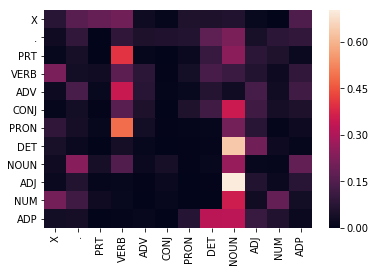

In [21]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
sns.heatmap(tags_df)
plt.show()

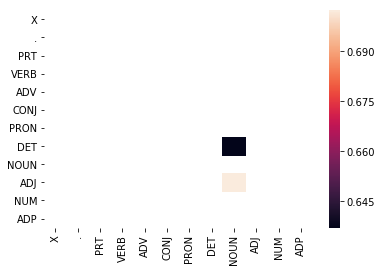

In [22]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
sns.heatmap(tags_frequent)
plt.show()

### Viterbi Algorithm

In [23]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



### Evaluating on Test Set

In [24]:
# Running on entire validation dataset
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(111)

# list of tagged words
test_run_base = [tup for sent in validation_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for combo in validation_set for tup in combo]
print(len(test_tagged_words))


# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

5241


In [25]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  2337.3582932949066
[('Diaper', 'NOUN'), ('shortages', 'X'), ('this', 'DET'), ('summer', 'NOUN'), ('limited', 'VERB'), ('growth', 'NOUN'), ('at', 'ADP'), ('Stork', 'X'), ('Diaper', 'NOUN'), ('Services', 'NOUN'), (',', '.'), ('Springfield', 'X'), (',', '.'), ('Mass.', 'NOUN'), (',', '.'), ('where', 'ADV'), ('business', 'NOUN'), ('is', 'VERB'), ('up', 'ADV'), ('25', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('*T*-1', 'X'), ('The', 'DET'), ('president', 'NOUN'), ('could', 'VERB'), ('probably', 'ADV'), ('not', 'ADV'), ('avoid', 'VERB'), ('this', 'DET'), ('restriction', 'NOUN'), ('by', 'ADP'), ('*-1', 'X'), ('choosing', 'VERB'), ('people', 'NOUN'), ('willing', 'ADJ'), ('*', 'X'), ('to', 'PRT'), ('serve', 'VERB'), ('without', 'ADP'), ('pay', 'NOUN'), (',', '.'), ('because', 'ADP'), ('the', 'DET'), ('Anti-Deficiency', 'X'), ('Act', 'NOUN'), ('prohibits', 'VERB'), ('voluntary', 'X'), ('service', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('government', 'NOUN'), ('.', '.'), ('Pa

In [26]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9055523755008587


In [27]:
# Lets check the incorrect cases
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('Diaper', 'NOUN'), (('shortages', 'X'), ('shortages', 'NOUN'))],
 [('at', 'ADP'), (('Stork', 'X'), ('Stork', 'NOUN'))],
 [(',', '.'), (('Springfield', 'X'), ('Springfield', 'NOUN'))],
 [('is', 'VERB'), (('up', 'ADV'), ('up', 'ADP'))],
 [('the', 'DET'), (('Anti-Deficiency', 'X'), ('Anti-Deficiency', 'NOUN'))],
 [('prohibits', 'VERB'), (('voluntary', 'X'), ('voluntary', 'ADJ'))],
 [('.', '.'), (('Pakistan', 'X'), ('Pakistan', 'NOUN'))],
 [("'s", 'PRT'), (('Bhutto', 'X'), ('Bhutto', 'NOUN'))],
 [('Bhutto', 'NOUN'), (('defeated', 'X'), ('defeated', 'VERB'))],
 [('first', 'ADJ'), (('no-confidence', 'X'), ('no-confidence', 'NOUN'))],
 [("'s", 'PRT'), (('42-year', 'X'), ('42-year', 'ADJ'))],
 [('vote', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('brought', 'VERB'), (('down', 'ADV'), ('down', 'PRT'))],
 [('her', 'PRON'), (('11-month-old', 'X'), ('11-month-old', 'ADJ'))],
 [('.', '.'), (('Abrupt', 'X'), ('Abrupt', 'ADJ'))],
 [('Abrupt', 'ADJ'), (('departures', 'X'), ('departures', 'NOUN

### Solve the problem of unknown words

In [28]:
# Lets collect all the words present in training
all_training_words = [word[0].upper() for word in train_tagged_words]
all_training_tags = [word[1].upper() for word in train_tagged_words]
print(all_training_words[:20])

['THE', 'PROBLEM', 'HERE', 'GOES', 'WELL', 'BEYOND', '*', 'TWISTING', 'LEGAL', 'DOCTRINE', '.', 'STEPHEN', 'SALMORE', ',', 'A', 'POLITICAL', 'SCIENTIST', 'AT', 'NEW', 'JERSEY']


In [29]:
# Lets see which ones are occuring for first time in the validation set
unknown_words_in_validation = [word for word in test_tagged_words if word.upper() not in all_training_words]
print(unknown_words_in_validation)

['shortages', 'Stork', 'Springfield', 'Anti-Deficiency', 'voluntary', 'Pakistan', 'Bhutto', 'defeated', 'no-confidence', '42-year', '11-month-old', 'Abrupt', 'departures', 'unheard', 'wherewithal', 'declare', 'cushion', 'stripped', 'Noriega', 'regime', '30,537', '21-month', 'Rev.', 'Jeremy', 'Hummerstone', '*T*-228', 'sacked', 'species', 'predicated', 'erroneous', 'Roman', 'numeral', 'IX', '*T*-196', 'discontinuing', 'contributors', 'multibillion-dollar', 'Danube', 'Austrian', 'Angelo', 'Gaja', 'Barbaresco', 'Piero', 'Antinori', 'Solaia', '1998', '95.09', '5.435', 'DeFazio', 'criteria', 'truthful', 'context', 'characterized', 'objectionable', 'conflict', 'Ogilvy', 'Mather', 'WPP', '27-year', 'information-services', 'twice', 'spoke', 'length', 'strains', '*T*-239', 'afflicted', 'Sino-U.S.', 'aghast', 'lofty', 'walking', 'ancestry', 'born', 'Puerto', 'Rico', 'quotations', 'PORTING', 'POTABLES', 'Scypher', 'Cup-Tote', 'C.D.s', 'augment', 'Rill', 'athletic', 'smallest', '*T*-162', '220', '

### Modifying vanilla Viterbi based POS tagger
### Approach 1

In [30]:
# Redefining Viterbi Heuristic so that if emission probability is 0, we are taking into consideration the transition
# probability
def Viterbi_modified_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            # If emission probability is 0, then setting it to very small number such that product of it with transition
            # probability is not zero.
            if emission_p == 0:
                emission_p == 0.001
            state_probability = emission_p * transition_p
            p.append(state_probability)
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))


In [31]:
# re-tagging the test sentences
start = time.time()
tagged_seq_1 = Viterbi_modified_1(test_tagged_words)
end = time.time()
difference = end-start
print(difference)

1420.579312801361


In [32]:
# accuracy
check_1 = [i for i, j in zip(tagged_seq_1, test_run_base) if i == j]
accuracy_1 = len(check_1)/len(tagged_seq)
print(accuracy_1)

0.9055523755008587


In [33]:
# Lets check the incorrect cases
incorrect_tagged_cases_1 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_1, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_1

[[('Diaper', 'NOUN'), (('shortages', 'X'), ('shortages', 'NOUN'))],
 [('at', 'ADP'), (('Stork', 'X'), ('Stork', 'NOUN'))],
 [(',', '.'), (('Springfield', 'X'), ('Springfield', 'NOUN'))],
 [('is', 'VERB'), (('up', 'ADV'), ('up', 'ADP'))],
 [('the', 'DET'), (('Anti-Deficiency', 'X'), ('Anti-Deficiency', 'NOUN'))],
 [('prohibits', 'VERB'), (('voluntary', 'X'), ('voluntary', 'ADJ'))],
 [('.', '.'), (('Pakistan', 'X'), ('Pakistan', 'NOUN'))],
 [("'s", 'PRT'), (('Bhutto', 'X'), ('Bhutto', 'NOUN'))],
 [('Bhutto', 'NOUN'), (('defeated', 'X'), ('defeated', 'VERB'))],
 [('first', 'ADJ'), (('no-confidence', 'X'), ('no-confidence', 'NOUN'))],
 [("'s", 'PRT'), (('42-year', 'X'), ('42-year', 'ADJ'))],
 [('vote', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('brought', 'VERB'), (('down', 'ADV'), ('down', 'PRT'))],
 [('her', 'PRON'), (('11-month-old', 'X'), ('11-month-old', 'ADJ'))],
 [('.', '.'), (('Abrupt', 'X'), ('Abrupt', 'ADJ'))],
 [('Abrupt', 'ADJ'), (('departures', 'X'), ('departures', 'NOUN

### Approach 2

In [34]:
# Hence as we checked, there is no improvement in the accuracy in approach 1
# On further analysis, it was found that all missing words were tagged as incorrect
# Hence modifying the algorithm further
# Lets see which is the most frequent tag in the training corpus
from collections import Counter
tag_counts = Counter(all_training_tags)
tag_counts

Counter({'DET': 8237,
         'NOUN': 27354,
         'ADV': 3000,
         'VERB': 12896,
         'ADP': 9308,
         'X': 6297,
         'ADJ': 6012,
         '.': 11142,
         'PRT': 3054,
         'PRON': 2608,
         'CONJ': 2157,
         'NUM': 3370})

In [35]:
# Redefining Viterbi Heuristic so that if probability is 0, we assign tag which is having highest probability of occurence
def Viterbi_modified_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
        pmax = max(p)
        # If pmax is 0, then it is a missing word. As we saw, there is maximum probability of Noun tag
        # So, lets classify all missing words as noun, and check if it helps with the accuracy score
        # probability is not zero.
        if pmax == 0:
            state_max = "NOUN"
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

In [36]:
# re-tagging the test sentences
start = time.time()
tagged_seq_2 = Viterbi_modified_2(test_tagged_words)
end = time.time()
difference = end-start
print(difference)

1837.5553188323975


In [37]:
# accuracy
check_2 = [i for i, j in zip(tagged_seq_2, test_run_base) if i == j]
accuracy_2 = len(check_2)/len(tagged_seq)
print(accuracy_2)

0.9372257202823888


In [38]:
# It looks like the accuracy was increased to ~93.7% which is a considerable jump over Vanilla Viterbi
# Lets check the cases which are still incorrect
incorrect_tagged_cases_2 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_2, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_2

[[('is', 'VERB'), (('up', 'ADV'), ('up', 'ADP'))],
 [('prohibits', 'VERB'), (('voluntary', 'NOUN'), ('voluntary', 'ADJ'))],
 [('Bhutto', 'NOUN'), (('defeated', 'NOUN'), ('defeated', 'VERB'))],
 [("'s", 'PRT'), (('42-year', 'NOUN'), ('42-year', 'ADJ'))],
 [('vote', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('brought', 'VERB'), (('down', 'ADV'), ('down', 'PRT'))],
 [('her', 'PRON'), (('11-month-old', 'NOUN'), ('11-month-old', 'ADJ'))],
 [('.', '.'), (('Abrupt', 'NOUN'), ('Abrupt', 'ADJ'))],
 [("n't", 'ADV'), (('unheard', 'NOUN'), ('unheard', 'ADJ'))],
 [('to', 'PRT'), (('as', 'ADP'), ('as', 'ADV'))],
 [('financial', 'ADJ'), (('wherewithal', 'NOUN'), ('wherewithal', 'ADJ'))],
 [('time', 'NOUN'), (('around', 'ADP'), ('around', 'PRT'))],
 [('to', 'PRT'), (('declare', 'NOUN'), ('declare', 'VERB'))],
 [('``', '.'), (('One', 'NUM'), ('One', 'NOUN'))],
 [('was', 'VERB'), (('stripped', 'NOUN'), ('stripped', 'VERB'))],
 [('of', 'ADP'), (('30,537', 'NOUN'), ('30,537', 'NUM'))],
 [('a', 'DET'

### Approach 3

In [39]:
# There are some patterns of the words for which we would use rule based tagger
# For rest of the words, we will continue to tag them with the hightest probability tagger
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*at$', 'DET'),                # Determinant
    (r'^\*T\*-', 'X'),                # Special numbers
    (r'[0-9,.\*]+', 'NUM'),           # Numbers
    (r'.*', 'NOUN')                   # nouns (default)
]
regexp_tagger = nltk.RegexpTagger(patterns)

In [40]:
# Redefining Viterbi Heuristic so that if word is unknown, then it uses regex tagger.
def Viterbi_modified_3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
        pmax = max(p)
        # If pmax is 0, then it is a missing word. As we saw, there is maximum probability of Noun tag
        # We will use regex tagger to find a tag for unknown words.
        if pmax == 0:
            regex_output = regexp_tagger.tag([word])
            state_max = regex_output[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))


In [41]:
# re-tagging the test sentences
start = time.time()
tagged_seq_3 = Viterbi_modified_3(test_tagged_words)
end = time.time()
difference = end-start
print(difference)

1828.4316630363464


In [42]:
# accuracy
check_3 = [i for i, j in zip(tagged_seq_3, test_run_base) if i == j]
accuracy_3 = len(check_3)/len(tagged_seq)
print(accuracy_3)

0.947529097500477


In [43]:
# It looks like the accuracy was increased to ~94.8% which is a considerable jump over Vanilla Viterbi
# Lets check the cases which are still incorrect
incorrect_tagged_cases_3 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_3, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_3

[[('Diaper', 'NOUN'), (('shortages', 'VERB'), ('shortages', 'NOUN'))],
 [('is', 'VERB'), (('up', 'ADV'), ('up', 'ADP'))],
 [('prohibits', 'VERB'), (('voluntary', 'NOUN'), ('voluntary', 'ADJ'))],
 [("'s", 'PRT'), (('42-year', 'NUM'), ('42-year', 'ADJ'))],
 [('vote', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('brought', 'VERB'), (('down', 'ADV'), ('down', 'PRT'))],
 [('her', 'PRON'), (('11-month-old', 'NUM'), ('11-month-old', 'ADJ'))],
 [('.', '.'), (('Abrupt', 'NOUN'), ('Abrupt', 'ADJ'))],
 [('Abrupt', 'ADJ'), (('departures', 'VERB'), ('departures', 'NOUN'))],
 [("n't", 'ADV'), (('unheard', 'NOUN'), ('unheard', 'ADJ'))],
 [('to', 'PRT'), (('as', 'ADP'), ('as', 'ADV'))],
 [('financial', 'ADJ'), (('wherewithal', 'NOUN'), ('wherewithal', 'ADJ'))],
 [('time', 'NOUN'), (('around', 'ADP'), ('around', 'PRT'))],
 [('to', 'PRT'), (('declare', 'NOUN'), ('declare', 'VERB'))],
 [('``', '.'), (('One', 'NUM'), ('One', 'NOUN'))],
 [('a', 'DET'), (('21-month', 'NUM'), ('21-month', 'ADJ'))],
 [('`

#### Evaluate tagging accuracy and compare the tagging accuracies of the modifications with the vanilla viterbi algorithm

##### Vanilla Viterbi provided a accuracy score of 0.90555

##### Approach 1 -> We redefined viterbi heuristic so that if emission probability is 0, we are taking into consideration the transition probability but that did not increase the accuracy score. Accuracy score was still at 0.90555

##### Approach 2 -> We redefined viterbi heuristic so that for unknown word, we assign tag which is having highest probability of occurence. Accuracy score was increased to 0.937

##### Approach 3 -> We captured some patterns for unknown words and we used rule based tagger to tag unknown words. Words which do not meet regex criteria, will continue to tagged them with the hightest probability tag. Accuracy score was then further increased to ~94.8%

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

##### Approach 2 and Approach 3 helped in increasing the accuracy score. Please find below some of the cases which were corrected by approaches against vanilla viterbi algorithm
##### 'shortages', 'Stork', 'Springfield', 'Anti-Deficiency', 'Bhutto', 'no-confidence' etc. such many words were correctly identified as Noun by approach 2
##### On top of approach 2 correct tags, approach 3 corrected tags of many other words: 
1. Words such as 'sacked', 'predicated', 'discontinuing', 'receives' were correctly labelled as VERB.
2. Words such as '*T*-111', '*T*-162' etc. were correctly labelled as X.
3. Numbers were correctly labelled as Numbers



### END OF ASSIGNMENT